# Momentum-Assisted Dynamic Attention with Rotary Positional Encoding (RoPE)
Kingsuk Maitra, Qualcomm Cloud AI

This notebook implements the attention mechanism described in Appendix-C:

**"Momentum-Assisted Dynamic Attention with Rotary Positional Encoding in a GPT-Style Decoder"**

## Key Concepts

1. **RoPE (Rotary Positional Encoding)**: Encodes position information through rotation matrices
2. **Momentum-Assisted Attention**: Incorporates temporal dynamics (velocity) into attention scores
3. **EMA Momentum**: Smooth estimation of sequence dynamics using exponential moving average

## Correct Computational Order

1. **Project** embeddings to Q, K, V using weight matrices $W_Q$, $W_K$, $W_V$
2. **Apply RoPE** to projected Q and K only (not V)
3. **Compute momentum** $P_Q$, $P_K$ as kinematic differences of RoPE-encoded Q and K
4. **Augment** Q and K only with momentum (V remains unchanged)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Rotary Positional Encoding (RoPE)

RoPE encodes position information by rotating embedding vectors in 2D subspaces.

For position $n$ and block $m$, the rotation angle is:
$$\phi_m(n) = \theta_m \cdot n$$

where $\theta_m = \text{base}^{-2m/d_{\text{model}}}$ (default base = 10000).

The rotation matrix is:
$$R(\phi) = \begin{bmatrix} \cos\phi & -\sin\phi \\ \sin\phi & \cos\phi \end{bmatrix}$$

**Important**: RoPE is applied to projected Q and K vectors, not to raw embeddings.

In [ ]:
def apply_rope(
    x: np.ndarray,
    positions: np.ndarray,
    theta: np.ndarray
) -> np.ndarray:
    """
    Apply Rotary Positional Encoding (RoPE) to projected Q or K vectors.

    Args:
        x: Shape (seq_len, d_k) - projected queries or keys
        positions: Shape (seq_len,) - position indices
        theta: Shape (num_blocks,) - rotation frequencies

    Returns:
        Rotated vectors of shape (seq_len, d_k)
    """
    seq_len, d_k = x.shape
    num_blocks = d_k // 2

    # Reshape to (seq_len, num_blocks, 2) for block-wise rotation
    x_reshaped = x.reshape(seq_len, num_blocks, 2)
    x_rotated = np.zeros_like(x_reshaped)

    # Apply rotation to each block
    for m in range(num_blocks):
        # Calculate angles: phi_m(n) = theta_m * n
        angles = theta[m] * positions  # (seq_len,)

        cos_angles = np.cos(angles)
        sin_angles = np.sin(angles)

        # Extract the two components of this block
        x0 = x_reshaped[:, m, 0]
        x1 = x_reshaped[:, m, 1]

        # Apply rotation
        x_rotated[:, m, 0] = cos_angles * x0 - sin_angles * x1
        x_rotated[:, m, 1] = sin_angles * x0 + cos_angles * x1

    return x_rotated.reshape(seq_len, d_k)

print("RoPE function defined")

RoPE function defined


## 2. EMA Momentum Calculation

We calculate momentum using an **Exponential Moving Average (EMA)** of the velocity.

**Correct Order**: Momentum is computed on RoPE-encoded Q and K vectors:

$$p_{q,n} = \beta \cdot p_{q,n-1} + (1 - \beta) \cdot (\tilde{q}_{n} - \tilde{q}_{n-1})$$
$$p_{k,n} = \beta \cdot p_{k,n-1} + (1 - \beta) \cdot (\tilde{k}_{n} - \tilde{k}_{n-1})$$

with $p_{q,0} = p_{k,0} = 0$ and $0 \leq \beta < 1$.

- Higher $\beta$ → smoother momentum (more memory of past)
- Lower $\beta$ → more responsive momentum (less memory)

In [ ]:
def calculate_momentum_ema(
    x_rotated: np.ndarray,
    beta: float = 0.9
) -> np.ndarray:
    """
    Calculate momentum using Exponential Moving Average (EMA).

    Args:
        x_rotated: RoPE-encoded Q or K vectors (seq_len, d_k)
        beta: EMA decay parameter (0 <= beta < 1)

    Returns:
        Momentum vectors of shape (seq_len, d_k)
    """
    seq_len, d_k = x_rotated.shape
    momentum = np.zeros((seq_len, d_k))

    # Initialize p_0 = 0
    p_prev = np.zeros(d_k)

    for n in range(seq_len):
        if n == 0:
            # First position: no previous vector
            velocity = np.zeros(d_k)
        else:
            # Velocity = kinematic difference
            velocity = x_rotated[n] - x_rotated[n-1]

        # EMA update
        p_current = beta * p_prev + (1 - beta) * velocity
        momentum[n] = p_current
        p_prev = p_current

    return momentum

print("EMA momentum function defined")

EMA momentum function defined


## 3. Momentum-Assisted Attention

The key innovation: augment queries and keys with momentum (values unchanged):

$$\hat{q}_i = \tilde{q}_i + \gamma_Q \cdot p_{q,i}$$
$$\hat{k}_j = \tilde{k}_j + \gamma_K \cdot p_{k,j}$$
$$\hat{v}_j = v_j \quad \text{(unchanged)}$$

## Correct Computational Pipeline

1. **Project**: $q_n = e_n W_Q$, $k_n = e_n W_K$, $v_n = e_n W_V$
2. **Apply RoPE** to Q and K only: $\tilde{q}_n = \text{RoPE}(q_n, n)$, $\tilde{k}_n = \text{RoPE}(k_n, n)$
3. **Compute momentum** from RoPE'd Q and K: $p_{q,n}$, $p_{k,n}$ via EMA of kinematic differences
4. **Augment** Q and K: $\hat{q}_i = \tilde{q}_i + \gamma_Q p_{q,i}$, $\hat{k}_j = \tilde{k}_j + \gamma_K p_{k,j}$
5. **Attention**: $\text{softmax}(\hat{Q}\hat{K}^T / \sqrt{d_k}) \cdot V$

In [ ]:
class MomentumRoPEAttention:
    """
    Momentum-assisted attention with Rotary Positional Encoding.

    Correct order:
    1. Project embeddings -> Q, K, V
    2. Apply RoPE to Q and K only
    3. Compute momentum P_Q, P_K from RoPE'd Q, K
    4. Augment Q and K with momentum (V unchanged)
    """

    def __init__(
        self,
        d_model: int,
        d_k: int,
        gamma_Q: float = 0.1,
        gamma_K: float = 0.1,
        beta: float = 0.9,
        rope_base: float = 10000.0
    ):
        """
        Args:
            d_model: Model dimension
            d_k: Key/query dimension (must be even for RoPE)
            gamma_Q: Momentum coupling strength for queries
            gamma_K: Momentum coupling strength for keys
            beta: EMA decay parameter
            rope_base: Base for RoPE frequencies
        """
        assert d_k % 2 == 0, "d_k must be even for RoPE"

        self.d_model = d_model
        self.d_k = d_k
        self.gamma_Q = gamma_Q
        self.gamma_K = gamma_K
        self.beta = beta

        # Weight matrices
        self.W_Q = np.random.randn(d_model, d_k) / np.sqrt(d_model)
        self.W_K = np.random.randn(d_model, d_k) / np.sqrt(d_model)
        self.W_V = np.random.randn(d_model, d_k) / np.sqrt(d_model)

        # RoPE frequencies for d_k dimension
        num_blocks = d_k // 2
        self.theta = rope_base ** (-2 * np.arange(num_blocks) / d_k)

    def forward(
        self,
        embeddings: np.ndarray,
        positions: Optional[np.ndarray] = None,
        return_intermediates: bool = False
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Forward pass with correct order:
        Project -> RoPE (Q,K only) -> Momentum (Q,K only) -> Attention

        Args:
            embeddings: Input embeddings (seq_len, d_model)
            positions: Position indices (seq_len,)
            return_intermediates: If True, return intermediate values

        Returns:
            output: Attention output (seq_len, d_k)
            attention_weights: Attention weights (seq_len, seq_len)
        """
        seq_len = embeddings.shape[0]

        if positions is None:
            positions = np.arange(seq_len)

        # Step 1: Project embeddings to Q, K, V
        Q = embeddings @ self.W_Q  # (seq_len, d_k)
        K = embeddings @ self.W_K  # (seq_len, d_k)
        V = embeddings @ self.W_V  # (seq_len, d_k)

        # Step 2: Apply RoPE to Q and K only (NOT to V)
        Q_rope = apply_rope(Q, positions, self.theta)  # (seq_len, d_k)
        K_rope = apply_rope(K, positions, self.theta)  # (seq_len, d_k)

        # Step 3: Compute momentum from RoPE'd Q and K
        P_Q = calculate_momentum_ema(Q_rope, self.beta)  # (seq_len, d_k)
        P_K = calculate_momentum_ema(K_rope, self.beta)  # (seq_len, d_k)

        # Step 4: Augment Q and K with momentum (V unchanged)
        Q_hat = Q_rope + self.gamma_Q * P_Q
        K_hat = K_rope + self.gamma_K * P_K
        # V_hat = V  (no momentum on values)

        # Step 5: Compute attention scores
        scores = (Q_hat @ K_hat.T) / np.sqrt(self.d_k)

        # Apply causal mask
        mask = np.tril(np.ones((seq_len, seq_len)))
        scores = np.where(mask == 1, scores, -np.inf)

        # Step 6: Softmax to get attention weights
        attention_weights = self._softmax(scores)

        # Step 7: Compute output (using V, not V_hat)
        output = attention_weights @ V

        if return_intermediates:
            return output, attention_weights, {
                'Q': Q, 'K': K, 'V': V,
                'Q_rope': Q_rope, 'K_rope': K_rope,
                'P_Q': P_Q, 'P_K': P_K,
                'Q_hat': Q_hat, 'K_hat': K_hat
            }

        return output, attention_weights

    @staticmethod
    def _softmax(x: np.ndarray) -> np.ndarray:
        """Numerically stable softmax."""
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

print("MomentumRoPEAttention class defined")
print("")
print("Correct computational order:")
print("  1. Project: e -> Q, K, V using W_Q, W_K, W_V")
print("  2. RoPE: Q -> Q_rope, K -> K_rope (V unchanged)")
print("  3. Momentum: Q_rope -> P_Q, K_rope -> P_K (kinematic differences)")
print("  4. Augment: Q_hat = Q_rope + γ_Q·P_Q, K_hat = K_rope + γ_K·P_K")
print("  5. Attention: softmax(Q_hat·K_hat^T/√d_k)·V")

MomentumRoPEAttention class defined

Correct computational order:
  1. Project: e -> Q, K, V using W_Q, W_K, W_V
  2. RoPE: Q -> Q_rope, K -> K_rope (V unchanged)
  3. Momentum: Q_rope -> P_Q, K_rope -> P_K (kinematic differences)
  4. Augment: Q_hat = Q_rope + γ_Q·P_Q, K_hat = K_rope + γ_K·P_K
  5. Attention: softmax(Q_hat·K_hat^T/√d_k)·V


## 4. Test: Visualize RoPE Effect

Let's see how RoPE rotates the projected Q vectors at different positions.

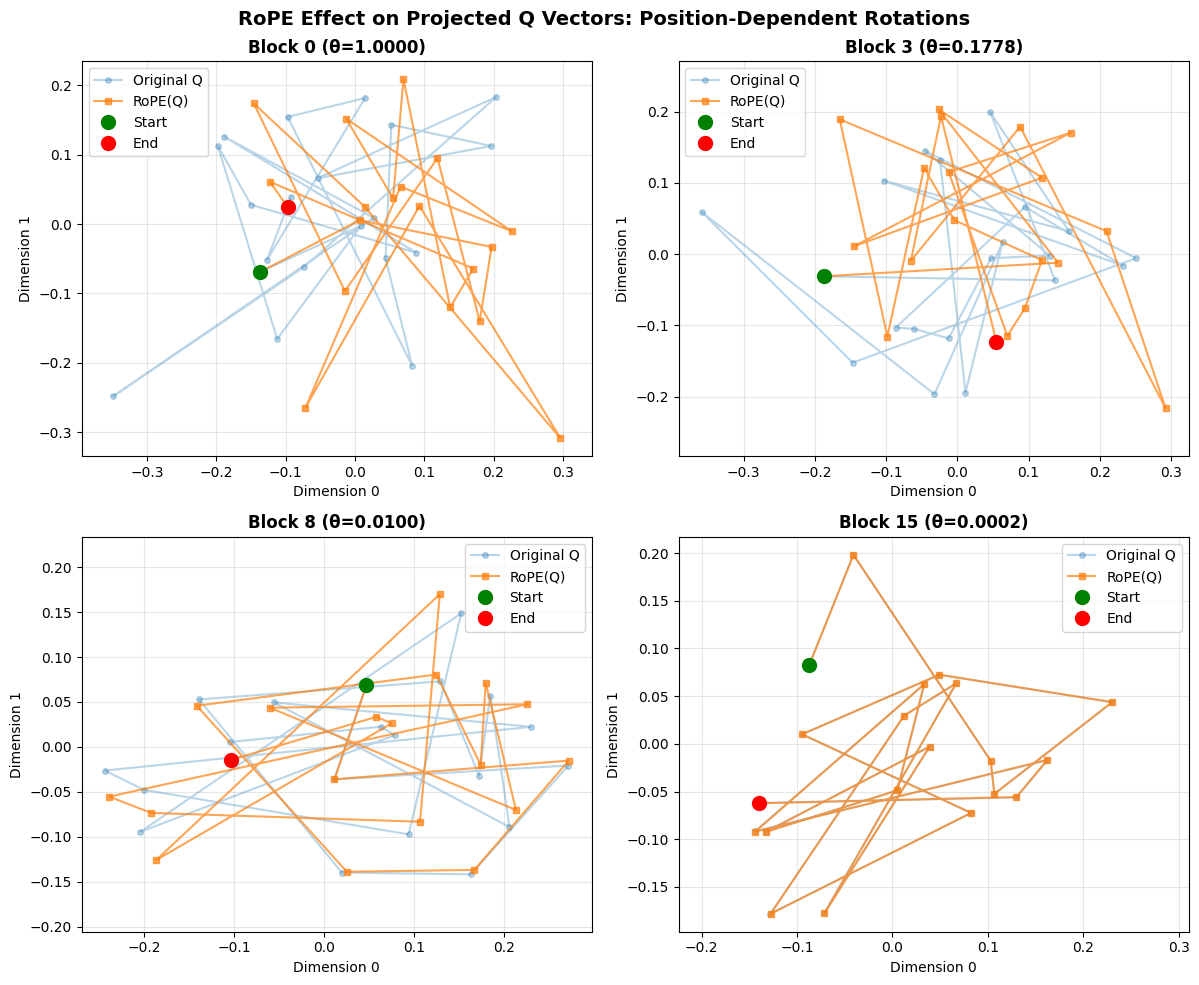


RoPE preserves norms: True

Correct order verified:
  1. Embeddings shape: (20, 64)
  2. Projected Q shape: (20, 32)
  3. RoPE(Q) shape: (20, 32)


In [ ]:
# Configuration
d_model = 64
d_k = 32
seq_len = 20

# Create simple embeddings
embeddings = np.random.randn(seq_len, d_model)
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Create weight matrix for Q
W_Q = np.random.randn(d_model, d_k) / np.sqrt(d_model)

# Project to Q
Q = embeddings @ W_Q

# Calculate RoPE frequencies for d_k
num_blocks = d_k // 2
theta = 10000.0 ** (-2 * np.arange(num_blocks) / d_k)

# Apply RoPE to projected Q
positions = np.arange(seq_len)
Q_rope = apply_rope(Q, positions, theta)

# Visualize first few blocks
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

blocks_to_plot = [0, 3, 8, 15]  # Different frequency blocks within d_k

for idx, block_idx in enumerate(blocks_to_plot):
    ax = axes[idx]

    # Extract this block (2D) from projected Q
    original = Q[:, block_idx*2:(block_idx+1)*2]
    rotated = Q_rope[:, block_idx*2:(block_idx+1)*2]

    # Plot trajectories
    ax.plot(original[:, 0], original[:, 1], 'o-', alpha=0.3, label='Original Q', markersize=4)
    ax.plot(rotated[:, 0], rotated[:, 1], 's-', alpha=0.7, label='RoPE(Q)', markersize=4)

    # Mark start and end
    ax.plot(rotated[0, 0], rotated[0, 1], 'go', markersize=10, label='Start')
    ax.plot(rotated[-1, 0], rotated[-1, 1], 'ro', markersize=10, label='End')

    ax.set_title(f'Block {block_idx} (θ={theta[block_idx]:.4f})', fontweight='bold')
    ax.set_xlabel('Dimension 0')
    ax.set_ylabel('Dimension 1')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axis('equal')

plt.suptitle('RoPE Effect on Projected Q Vectors: Position-Dependent Rotations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nRoPE preserves norms: {np.allclose(np.linalg.norm(Q, axis=1), np.linalg.norm(Q_rope, axis=1))}")
print(f"\nCorrect order verified:")
print(f"  1. Embeddings shape: {embeddings.shape}")
print(f"  2. Projected Q shape: {Q.shape}")
print(f"  3. RoPE(Q) shape: {Q_rope.shape}")

## 5. Test: EMA Momentum Behavior

Let's visualize how EMA smooths the momentum estimates computed from RoPE'd Q vectors.

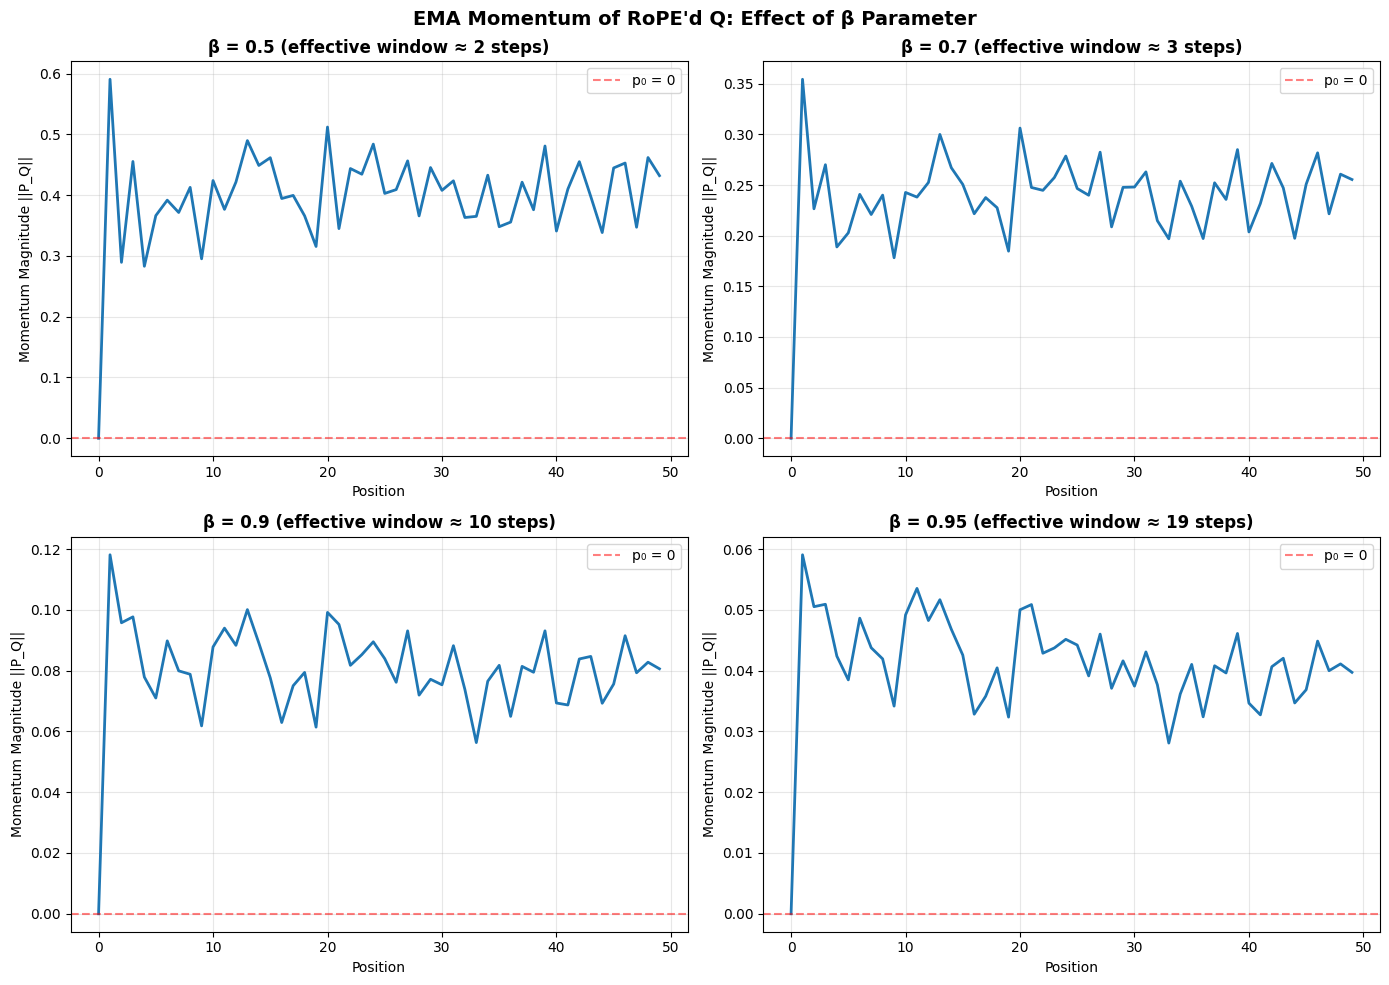


Observations:
- Higher β → smoother momentum (more memory)
- Lower β → more responsive momentum (less memory)
- All start at zero: p₀ = 0

Correct order: Momentum computed from RoPE'd Q (after projection and RoPE)


In [ ]:
# Create a sequence with varying dynamics
seq_len = 50
d_model = 64
d_k = 32

t = np.linspace(0, 4*np.pi, seq_len)

# Create embeddings with temporal pattern
embeddings_test = np.zeros((seq_len, d_model))
for i in range(d_model):
    freq = 0.5 + 0.1 * i
    embeddings_test[:, i] = np.sin(freq * t) + 0.2 * np.random.randn(seq_len)

embeddings_test = embeddings_test / np.linalg.norm(embeddings_test, axis=1, keepdims=True)

# Project to Q and apply RoPE
W_Q_test = np.random.randn(d_model, d_k) / np.sqrt(d_model)
Q_test = embeddings_test @ W_Q_test

num_blocks = d_k // 2
theta_test = 10000.0 ** (-2 * np.arange(num_blocks) / d_k)
positions_test = np.arange(seq_len)
Q_rope_test = apply_rope(Q_test, positions_test, theta_test)

# Calculate momentum with different beta values
beta_values = [0.5, 0.7, 0.9, 0.95]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, beta in enumerate(beta_values):
    # Compute momentum from RoPE'd Q
    P_Q = calculate_momentum_ema(Q_rope_test, beta)
    momentum_norms = np.linalg.norm(P_Q, axis=1)

    ax = axes[idx]
    ax.plot(momentum_norms, linewidth=2)
    ax.set_title(f'β = {beta} (effective window ≈ {int(1/(1-beta))} steps)', fontweight='bold')
    ax.set_xlabel('Position')
    ax.set_ylabel('Momentum Magnitude ||P_Q||')
    ax.grid(True, alpha=0.3)

    # Show that first position is zero
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='p₀ = 0')
    ax.legend()

plt.suptitle('EMA Momentum of RoPE\'d Q: Effect of β Parameter', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Higher β → smoother momentum (more memory)")
print("- Lower β → more responsive momentum (less memory)")
print("- All start at zero: p₀ = 0")
print("\nCorrect order: Momentum computed from RoPE'd Q (after projection and RoPE)")

## 6. Main Experiment: Attention Pattern Comparison

Compare attention patterns with and without momentum.


No Momentum:
  Average entropy: 2.549
  Attention spread (std): 0.0410

Weak Momentum:
  Average entropy: 2.549
  Attention spread (std): 0.0410

Moderate Momentum:
  Average entropy: 2.549
  Attention spread (std): 0.0410

Strong Momentum:
  Average entropy: 2.549
  Attention spread (std): 0.0410


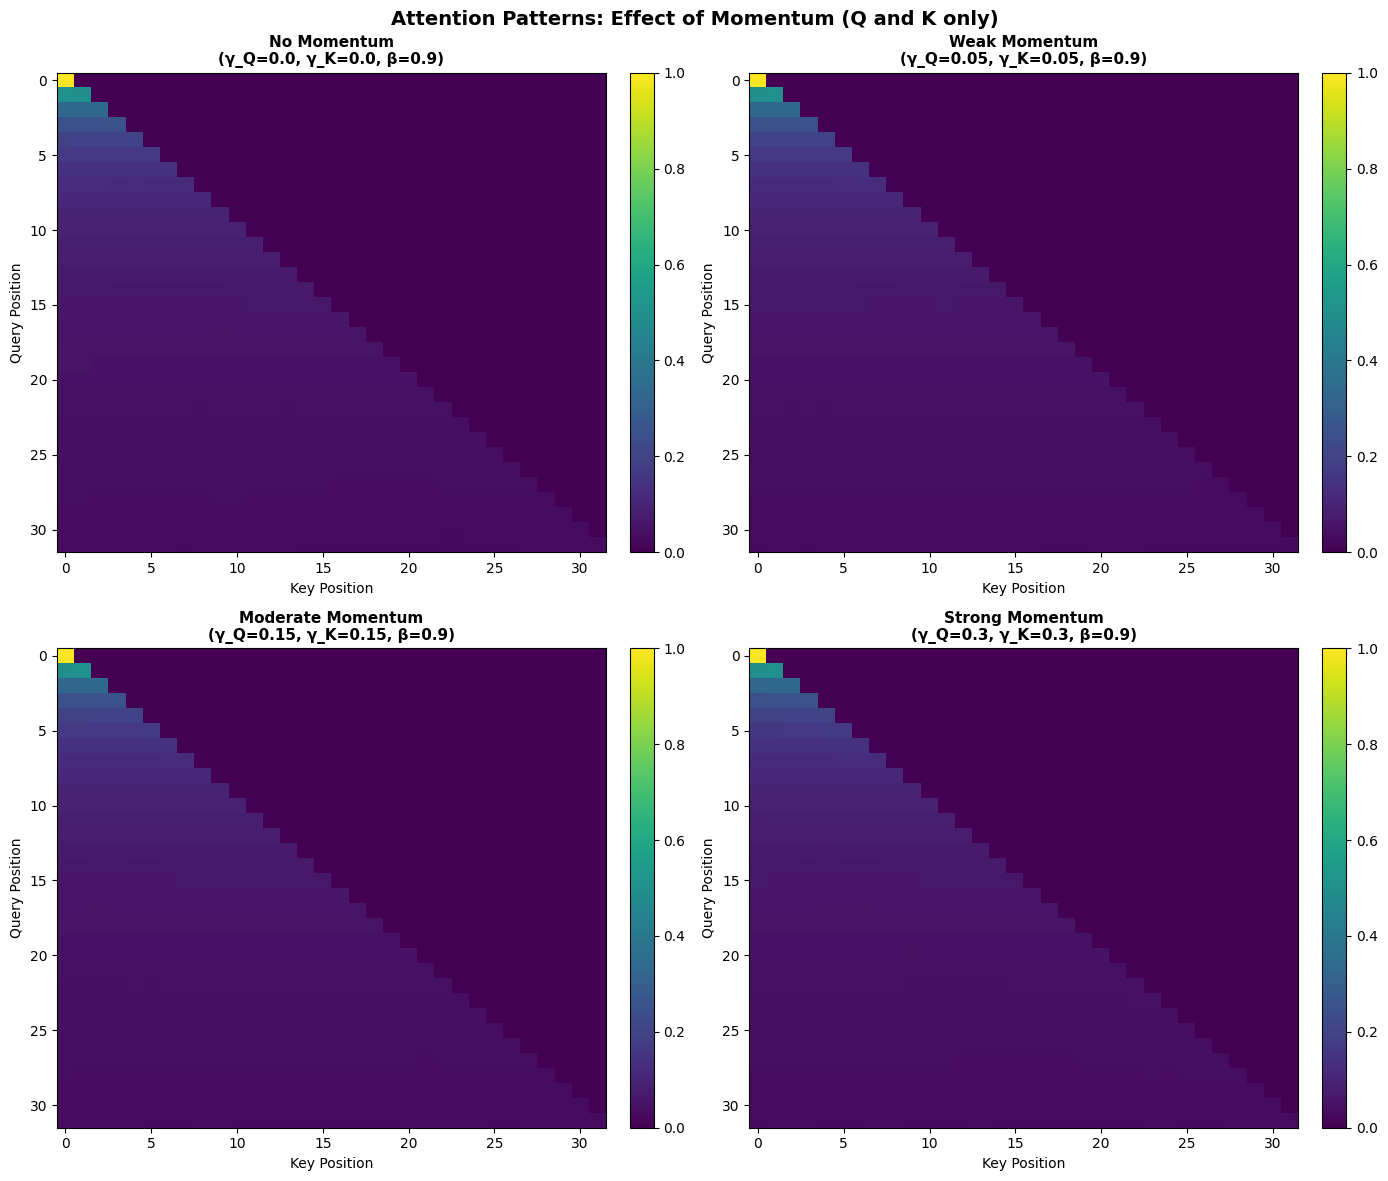

In [ ]:
# Create sequence with temporal structure
seq_len = 32
d_model = 64
d_k = 32

# Generate embeddings with smooth temporal evolution
t = np.linspace(0, 2*np.pi, seq_len)
embeddings = np.zeros((seq_len, d_model))
for i in range(d_model):
    phase = 2 * np.pi * np.random.rand()
    freq = 1 + 0.5 * np.sin(2 * np.pi * i / d_model)
    embeddings[:, i] = np.sin(freq * t + phase) + 0.1 * np.random.randn(seq_len)

embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Test configurations (no gamma_V since V is unchanged)
configs = [
    ("No Momentum", 0.0, 0.0, 0.9),
    ("Weak Momentum", 0.05, 0.05, 0.9),
    ("Moderate Momentum", 0.15, 0.15, 0.9),
    ("Strong Momentum", 0.3, 0.3, 0.9),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (name, gamma_Q, gamma_K, beta) in enumerate(configs):
    # Create attention layer
    attention = MomentumRoPEAttention(
        d_model=d_model,
        d_k=d_k,
        gamma_Q=gamma_Q,
        gamma_K=gamma_K,
        beta=beta
    )

    # Forward pass
    output, attention_weights = attention.forward(embeddings)

    # Plot attention weights
    ax = axes[idx]
    im = ax.imshow(attention_weights, cmap='viridis', aspect='auto')
    ax.set_title(f'{name}\n(γ_Q={gamma_Q}, γ_K={gamma_K}, β={beta})', fontsize=11, fontweight='bold')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Statistics
    entropy = -np.sum(attention_weights * np.log(attention_weights + 1e-10), axis=1)
    print(f"\n{name}:")
    print(f"  Average entropy: {np.mean(entropy):.3f}")
    print(f"  Attention spread (std): {np.mean(np.std(attention_weights, axis=1)):.4f}")

plt.suptitle('Attention Patterns: Effect of Momentum (Q and K only)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Analysis: Momentum Impact on Attention

Let's examine how momentum modifies the attention scores.

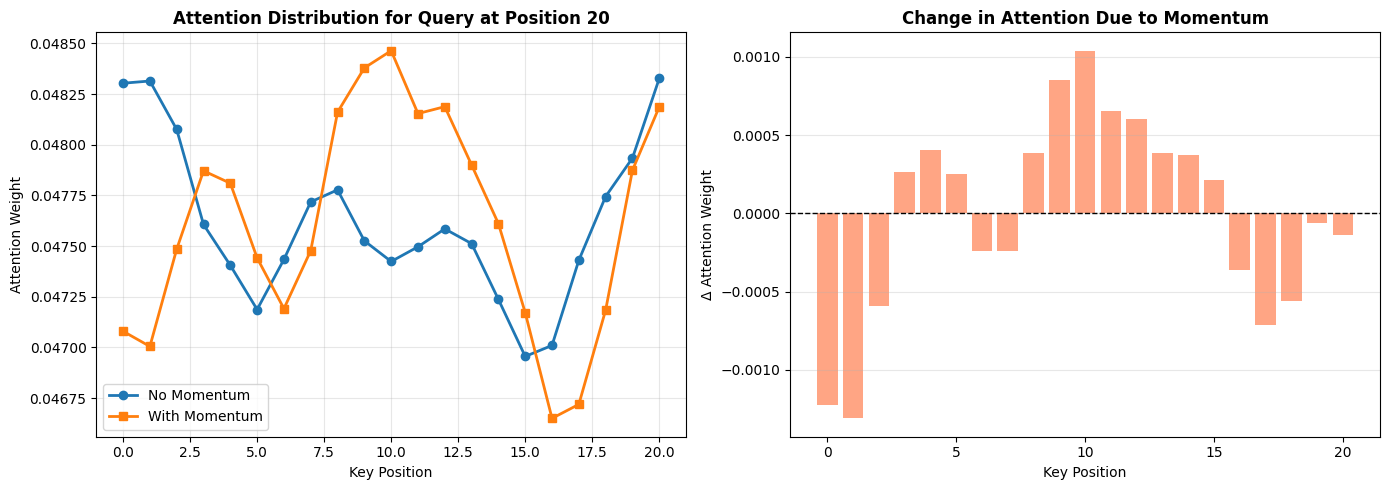


Query position 20:
Max attention without momentum: position 20
Max attention with momentum: position 10
Total absolute change: 0.0109


In [ ]:
# Compare a single query position with and without momentum
query_pos = 20

# No momentum
attn_no_momentum = MomentumRoPEAttention(
    d_model=d_model, d_k=d_k,
    gamma_Q=0.0, gamma_K=0.0
)
_, weights_no_momentum = attn_no_momentum.forward(embeddings)

# With momentum
attn_with_momentum = MomentumRoPEAttention(
    d_model=d_model, d_k=d_k,
    gamma_Q=0.15, gamma_K=0.15
)
_, weights_with_momentum = attn_with_momentum.forward(embeddings)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Attention weights for specific query
ax = axes[0]
ax.plot(weights_no_momentum[query_pos, :query_pos+1], 'o-', label='No Momentum', linewidth=2)
ax.plot(weights_with_momentum[query_pos, :query_pos+1], 's-', label='With Momentum', linewidth=2)
ax.set_xlabel('Key Position')
ax.set_ylabel('Attention Weight')
ax.set_title(f'Attention Distribution for Query at Position {query_pos}', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Difference in attention weights
ax = axes[1]
difference = weights_with_momentum[query_pos, :query_pos+1] - weights_no_momentum[query_pos, :query_pos+1]
ax.bar(range(query_pos+1), difference, alpha=0.7, color='coral')
ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax.set_xlabel('Key Position')
ax.set_ylabel('Δ Attention Weight')
ax.set_title('Change in Attention Due to Momentum', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nQuery position {query_pos}:")
print(f"Max attention without momentum: position {np.argmax(weights_no_momentum[query_pos, :query_pos+1])}")
print(f"Max attention with momentum: position {np.argmax(weights_with_momentum[query_pos, :query_pos+1])}")
print(f"Total absolute change: {np.sum(np.abs(difference)):.4f}")

## 8. Deep Dive: Component Analysis

Let's decompose the attention score into its components using the correct order.

<>:35: SyntaxWarning: invalid escape sequence '\g'
<>:36: SyntaxWarning: invalid escape sequence '\g'
<>:37: SyntaxWarning: invalid escape sequence '\g'
<>:35: SyntaxWarning: invalid escape sequence '\g'
<>:36: SyntaxWarning: invalid escape sequence '\g'
<>:37: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-4056886656.py:35: SyntaxWarning: invalid escape sequence '\g'
  (component_pq, f'Query Momentum - Key Position\n$\gamma_Q p_{{q,i}}^T \\tilde{{k}}_j$ (γ={attention.gamma_Q})', 'green'),
/tmp/ipython-input-4056886656.py:36: SyntaxWarning: invalid escape sequence '\g'
  (component_qp, f'Query Position - Key Momentum\n$\gamma_K \\tilde{{q}}_i^T p_{{k,j}}$ (γ={attention.gamma_K})', 'orange'),
/tmp/ipython-input-4056886656.py:37: SyntaxWarning: invalid escape sequence '\g'
  (component_pp, f'Momentum-Momentum\n$\gamma_Q \gamma_K p_{{q,i}}^T p_{{k,j}}$', 'red')


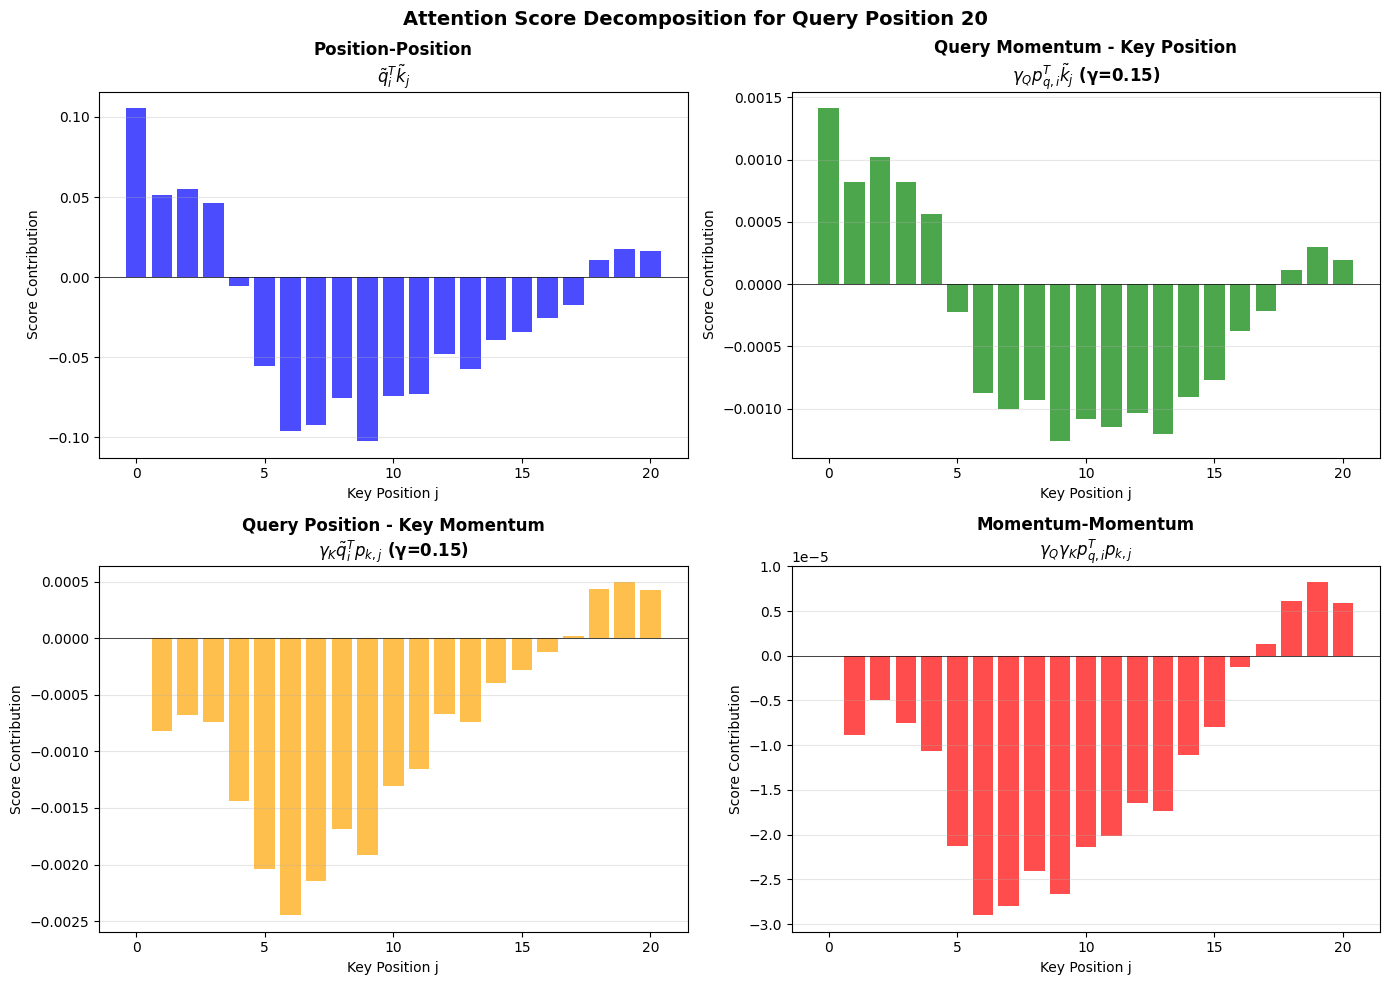


Relative magnitudes:
  Position-position (Q̃·K̃): 0.0523
  Query momentum-key position: 0.0008
  Query position-key momentum: 0.0009
  Momentum-momentum: 0.000013


In [ ]:
# Create attention layer and get intermediates
attention = MomentumRoPEAttention(
    d_model=d_model,
    d_k=d_k,
    gamma_Q=0.15,
    gamma_K=0.15,
    beta=0.9
)

# Get intermediate values
output, attn_weights, intermediates = attention.forward(embeddings, return_intermediates=True)

Q_rope = intermediates['Q_rope']
K_rope = intermediates['K_rope']
P_Q = intermediates['P_Q']
P_K = intermediates['P_K']

# Decompose attention score for specific query
i = 20
j_values = np.arange(i+1)

# Components:
# l_ij = (1/√d_k) * [q̃_i^T k̃_j + γ_Q p_q,i^T k̃_j + γ_K q̃_i^T p_k,j + γ_Q γ_K p_q,i^T p_k,j]

component_qq = Q_rope[i] @ K_rope[j_values].T  # RoPE'd Q - RoPE'd K
component_pq = attention.gamma_Q * (P_Q[i] @ K_rope[j_values].T)  # Query momentum - RoPE'd K
component_qp = attention.gamma_K * (Q_rope[i] @ P_K[j_values].T)  # RoPE'd Q - Key momentum
component_pp = attention.gamma_Q * attention.gamma_K * (P_Q[i] @ P_K[j_values].T)  # Momentum-momentum

# Plot decomposition
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

components = [
    (component_qq, 'Position-Position\n$\\tilde{q}_i^T \\tilde{k}_j$', 'blue'),
    (component_pq, f'Query Momentum - Key Position\n$\gamma_Q p_{{q,i}}^T \\tilde{{k}}_j$ (γ={attention.gamma_Q})', 'green'),
    (component_qp, f'Query Position - Key Momentum\n$\gamma_K \\tilde{{q}}_i^T p_{{k,j}}$ (γ={attention.gamma_K})', 'orange'),
    (component_pp, f'Momentum-Momentum\n$\gamma_Q \gamma_K p_{{q,i}}^T p_{{k,j}}$', 'red')
]

for idx, (component, title, color) in enumerate(components):
    ax = axes[idx // 2, idx % 2]
    ax.bar(j_values, component, alpha=0.7, color=color)
    ax.set_xlabel('Key Position j')
    ax.set_ylabel('Score Contribution')
    ax.set_title(title, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

plt.suptitle(f'Attention Score Decomposition for Query Position {i}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nRelative magnitudes:")
print(f"  Position-position (Q̃·K̃): {np.mean(np.abs(component_qq)):.4f}")
print(f"  Query momentum-key position: {np.mean(np.abs(component_pq)):.4f}")
print(f"  Query position-key momentum: {np.mean(np.abs(component_qp)):.4f}")
print(f"  Momentum-momentum: {np.mean(np.abs(component_pp)):.6f}")

## 9. Verification: Correct Computational Order

Verify that we're following the correct order: Project → RoPE → Momentum

In [ ]:
print("Computational Order Verification:")
print("=" * 60)

print("\n✓ Step 1: Project embeddings to Q, K, V")
print(f"  Embeddings shape: {embeddings.shape}")
print(f"  W_Q shape: {attention.W_Q.shape}")
print(f"  W_K shape: {attention.W_K.shape}")
print(f"  W_V shape: {attention.W_V.shape}")
print(f"  Q = e @ W_Q → shape: {intermediates['Q'].shape}")
print(f"  K = e @ W_K → shape: {intermediates['K'].shape}")
print(f"  V = e @ W_V → shape: {intermediates['V'].shape}")

print("\n✓ Step 2: Apply RoPE to Q and K only")
print(f"  Q_rope = RoPE(Q) → shape: {intermediates['Q_rope'].shape}")
print(f"  K_rope = RoPE(K) → shape: {intermediates['K_rope'].shape}")
print(f"  V unchanged (no RoPE)")
print(f"  RoPE preserves norms: {np.allclose(np.linalg.norm(intermediates['Q'], axis=1), np.linalg.norm(intermediates['Q_rope'], axis=1))}")

print("\n✓ Step 3: Compute momentum from RoPE'd Q and K")
print(f"  P_Q = EMA(Q_rope[n] - Q_rope[n-1]) → shape: {intermediates['P_Q'].shape}")
print(f"  P_K = EMA(K_rope[n] - K_rope[n-1]) → shape: {intermediates['P_K'].shape}")
print(f"  P_Q[0] = 0: {np.allclose(intermediates['P_Q'][0], 0)}")
print(f"  P_K[0] = 0: {np.allclose(intermediates['P_K'][0], 0)}")

print("\n✓ Step 4: Augment Q and K with momentum")
print(f"  Q_hat = Q_rope + γ_Q·P_Q → shape: {intermediates['Q_hat'].shape}")
print(f"  K_hat = K_rope + γ_K·P_K → shape: {intermediates['K_hat'].shape}")
print(f"  γ_Q = {attention.gamma_Q}, γ_K = {attention.gamma_K}")
print(f"  V unchanged (no momentum augmentation)")

print("\n✓ Step 5: Compute attention")
print(f"  scores = Q_hat @ K_hat.T / √d_k")
print(f"  attention = softmax(scores) @ V  (using original V)")

print("\n" + "=" * 60)
print("CORRECT ORDER VERIFIED:")
print("  Embed → Project(W_Q,W_K,W_V) → RoPE(Q,K) → Momentum(Q,K) → Attention")
print("=" * 60)

Computational Order Verification:

✓ Step 1: Project embeddings to Q, K, V
  Embeddings shape: (32, 64)
  W_Q shape: (64, 32)
  W_K shape: (64, 32)
  W_V shape: (64, 32)
  Q = e @ W_Q → shape: (32, 32)
  K = e @ W_K → shape: (32, 32)
  V = e @ W_V → shape: (32, 32)

✓ Step 2: Apply RoPE to Q and K only
  Q_rope = RoPE(Q) → shape: (32, 32)
  K_rope = RoPE(K) → shape: (32, 32)
  V unchanged (no RoPE)
  RoPE preserves norms: True

✓ Step 3: Compute momentum from RoPE'd Q and K
  P_Q = EMA(Q_rope[n] - Q_rope[n-1]) → shape: (32, 32)
  P_K = EMA(K_rope[n] - K_rope[n-1]) → shape: (32, 32)
  P_Q[0] = 0: True
  P_K[0] = 0: True

✓ Step 4: Augment Q and K with momentum
  Q_hat = Q_rope + γ_Q·P_Q → shape: (32, 32)
  K_hat = K_rope + γ_K·P_K → shape: (32, 32)
  γ_Q = 0.15, γ_K = 0.15
  V unchanged (no momentum augmentation)

✓ Step 5: Compute attention
  scores = Q_hat @ K_hat.T / √d_k
  attention = softmax(scores) @ V  (using original V)

CORRECT ORDER VERIFIED:
  Embed → Project(W_Q,W_K,W_V) → R

## 10. Parameter Sensitivity Analysis

Explore how different parameters affect attention patterns.

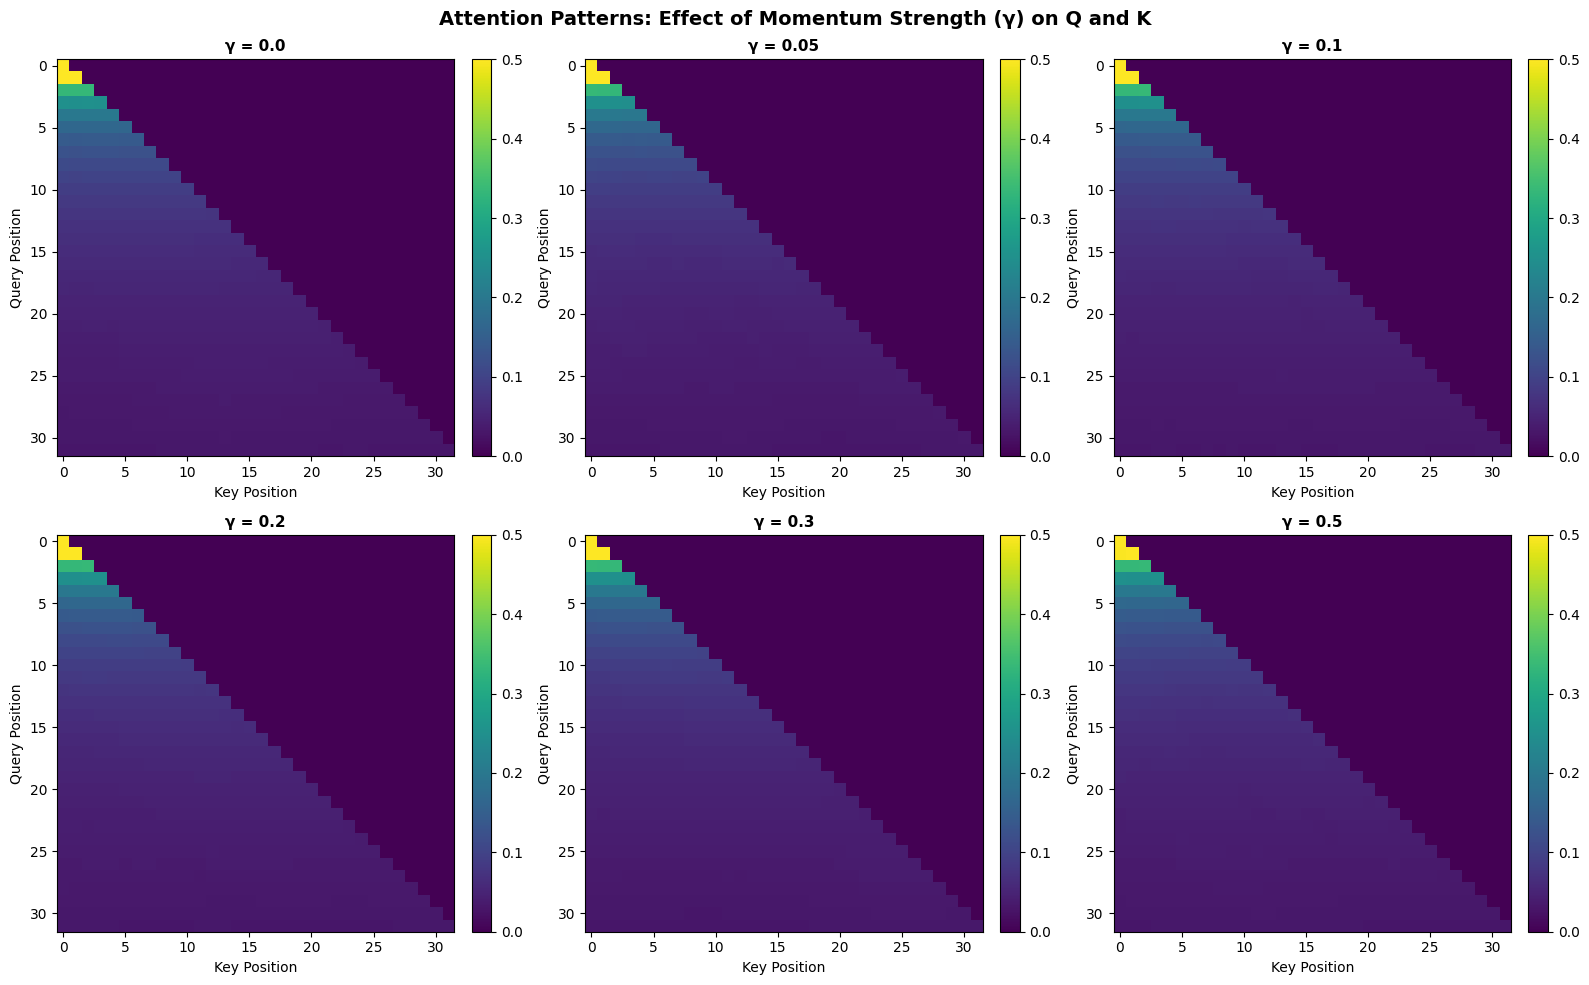

In [ ]:
# Test different gamma values
gamma_values = [0.0, 0.05, 0.1, 0.2, 0.3, 0.5]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, gamma in enumerate(gamma_values):
    attention = MomentumRoPEAttention(
        d_model=d_model,
        d_k=d_k,
        gamma_Q=gamma,
        gamma_K=gamma,
        beta=0.9
    )

    _, attention_weights = attention.forward(embeddings)

    ax = axes[idx]
    im = ax.imshow(attention_weights, cmap='viridis', aspect='auto', vmin=0, vmax=0.5)
    ax.set_title(f'γ = {gamma}', fontweight='bold', fontsize=11)
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Attention Patterns: Effect of Momentum Strength (γ) on Q and K',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Summary and Key Takeaways

### Correct Computational Order:

1. **Project**: $e \rightarrow Q, K, V$ using $W_Q, W_K, W_V$
2. **RoPE**: Apply to Q and K only → $\tilde{Q}, \tilde{K}$ (V unchanged)
3. **Momentum**: Compute $P_Q, P_K$ from kinematic differences of $\tilde{Q}, \tilde{K}$
4. **Augment**: $\hat{Q} = \tilde{Q} + \gamma_Q P_Q$, $\hat{K} = \tilde{K} + \gamma_K P_K$ (V unchanged)
5. **Attention**: $\text{softmax}(\hat{Q}\hat{K}^T/\sqrt{d_k}) \cdot V$

### Key Points:

- **RoPE applied AFTER projection**: Rotates in the projected Q/K space, not embedding space
- **Momentum computed AFTER RoPE**: Captures dynamics in the position-encoded space
- **V unchanged**: No RoPE, no momentum augmentation on values
- **Momentum on Q and K only**: Affects attention scores, not the values being aggregated

### Implementation Highlights:

1. **RoPE Encoding**: Applied to projected Q and K vectors
   - Preserves norms (orthogonal transformation)
   - Different frequencies for different blocks

2. **EMA Momentum**: Computed from RoPE'd Q and K
   - $p_{q,n} = \beta \cdot p_{q,n-1} + (1-\beta) \cdot (\tilde{q}_n - \tilde{q}_{n-1})$
   - $p_{k,n} = \beta \cdot p_{k,n-1} + (1-\beta) \cdot (\tilde{k}_n - \tilde{k}_{n-1})$

3. **Four interaction terms** in attention score:
   - $\tilde{q}_i^T \tilde{k}_j$ (position-position)
   - $\gamma_Q p_{q,i}^T \tilde{k}_j$ (query momentum - key position)
   - $\gamma_K \tilde{q}_i^T p_{k,j}$ (query position - key momentum)
   - $\gamma_Q \gamma_K p_{q,i}^T p_{k,j}$ (momentum-momentum)

In [ ]:
print("="*70)
print("Implementation Complete - CORRECT ORDER")
print("="*70)
print("\n✓ Correct computational pipeline:")
print("  1. Project: e → Q, K, V using W_Q, W_K, W_V")
print("  2. RoPE: Q → Q̃, K → K̃ (V unchanged)")
print("  3. Momentum: Q̃ → P_Q, K̃ → P_K (kinematic differences)")
print("  4. Augment: Q̂ = Q̃ + γ_Q·P_Q, K̂ = K̃ + γ_K·P_K (V unchanged)")
print("  5. Attention: softmax(Q̂·K̂ᵀ/√d_k)·V")
print("\n✓ Key differences from previous version:")
print("  • RoPE applied AFTER projection (not to embeddings)")
print("  • Momentum computed from RoPE'd Q,K (not from RoPE'd embeddings)")
print("  • V has NO RoPE and NO momentum augmentation")
print("  • Only γ_Q and γ_K parameters (no γ_V)")
print("\n✓ Ready for experiments!")
print("="*70)

Implementation Complete - CORRECT ORDER

✓ Correct computational pipeline:
  1. Project: e → Q, K, V using W_Q, W_K, W_V
  2. RoPE: Q → Q̃, K → K̃ (V unchanged)
  3. Momentum: Q̃ → P_Q, K̃ → P_K (kinematic differences)
  4. Augment: Q̂ = Q̃ + γ_Q·P_Q, K̂ = K̃ + γ_K·P_K (V unchanged)
  5. Attention: softmax(Q̂·K̂ᵀ/√d_k)·V

✓ Key differences from previous version:
  • RoPE applied AFTER projection (not to embeddings)
  • Momentum computed from RoPE'd Q,K (not from RoPE'd embeddings)
  • V has NO RoPE and NO momentum augmentation
  • Only γ_Q and γ_K parameters (no γ_V)

✓ Ready for experiments!
